In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import warnings
warnings.filterwarnings("ignore")

In [75]:
#Directory path where data is stored
#Dataset name
#Directory to save the panaroma
#Is blurring the image needed
DataDirectoryPath="Datasets/"
DataSet="2/"
resultDir="Results/"
resultName="stitchedImg4.jpg"
blurImage=True
blurKernelSize=5
blurSigma=2
patchSize=5


In [59]:
#Hessian corner detection threshold
#Patch MSE difference threshold
#Proximity threshold (L2 norm between coordinates)
cornerThreshold=350
matchingThreshold=20
proximityThreshold=300

In [4]:
#Funcction to draw circles around corners
def drawCircles(img,points,radius=50):
    for i in points:
        img=cv2.circle(img, (i[1], i[0]), radius, (255,0,0), 5)
    return img   

In [5]:
#Hessian corner detection code 
def HessianCornerDetection(img,cornerThreshold=cornerThreshold):
    dervX=np.array([[-1.0,0.0,1.0],[-1.0,0.0,1.0],[-1.0,0.0,1.0]])
    dervY=np.array([[-1.0,-1.0,-1.0],[0.0,0.0,0.0],[1.0,1.0,1.0]])
    
    Ix=cv2.filter2D(img,ddepth=cv2.CV_64F,kernel=dervX)
    Iy=cv2.filter2D(img,ddepth=cv2.CV_64F,kernel=dervY)
    Ixx=cv2.filter2D(Ix,ddepth=cv2.CV_64F,kernel=dervX)
    Iyy=cv2.filter2D(Iy,ddepth=cv2.CV_64F,kernel=dervY)
    Ixy=cv2.filter2D(Ix,ddepth=cv2.CV_64F,kernel=dervY)
    Iyx=cv2.filter2D(Iy,ddepth=cv2.CV_64F,kernel=dervX)
    
    cornerPoints=[]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            minEigValue=np.min(np.abs(np.linalg.eigvals(np.array([[Ixx[i][j], Ixy[i][j]],[Iyx[i][j], Iyy[i][j]]]))))
            if np.abs(minEigValue) > cornerThreshold:
                cornerPoints.append([i,j])
    
    return np.array(cornerPoints)

In [6]:
def findL2Norm(patch1,patch2):            
    return np.sum(np.square(patch1-patch2))

In [7]:
#HOG descriptor code (but not used for image stitching)
def HOG(patch,bin_size=9):
    hog=np.zeros(bin_size)
    
    dervX=np.array([[-1.0,0.0,1.0],[-1.0,0.0,1.0],[-1.0,0.0,1.0]])
    dervY=np.array([[-1.0,-1.0,-1.0],[0.0,0.0,0.0],[1.0,1.0,1.0]])
    
    Ix=cv2.filter2D(patch,ddepth=cv2.CV_64F,kernel=dervX)
    Iy=cv2.filter2D(patch,ddepth=cv2.CV_64F,kernel=dervY)
    
    for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
            gradMag=np.sqrt(Ix[i][j]**2+Iy[i][j]**2)
            gradAngle=math.atan(Iy[i][j]/(Ix[i][j]+0.00001))+1.5708
            bucketWidth=2*1.5708/bin_size
            idx=int(gradAngle/bucketWidth)
            hog[idx]+=gradMag
    return hog/np.linalg.norm(hog)



In [8]:
#Normalising the patch
def meanNormalisation(patch):
    return (patch-np.mean(patch))/np.std(patch)

In [9]:
#Finding the matching corners in two images
def matchingCorners(img1,img2,matchingThreshold=matchingThreshold):
    cornerPoints1=HessianCornerDetection(img1,cornerThreshold=cornerThreshold)
    cornerPoints2=HessianCornerDetection(img2,cornerThreshold=cornerThreshold)
    commonCorners1=[]
    commonCorners2=[]
    
    for i in range(len(cornerPoints1)):
        leftCornerX=cornerPoints1[i][0]-patchSize
        leftCornerY=cornerPoints1[i][1]-patchSize
        rightCornerX=cornerPoints1[i][0]+patchSize
        rightCornerY=cornerPoints1[i][1]+patchSize
        
        if leftCornerX<0 or leftCornerY<0 or rightCornerX>img1.shape[0] or rightCornerY>img1.shape[1]:
            continue
        
        patch1=img1[leftCornerX:rightCornerX,leftCornerY:rightCornerY]
        bestMatchScore=-1
        bestMatchIndex=-1
        feature1=meanNormalisation(patch1)
        
        for j in range(len(cornerPoints2)):
            #if np.linalg.norm(cornerPoints2[j]-cornerPoints1[i])>proximityThreshold:
            #    continue
            leftCornerX=cornerPoints2[j][0]-patchSize
            leftCornerY=cornerPoints2[j][1]-patchSize
            rightCornerX=cornerPoints2[j][0]+patchSize
            rightCornerY=cornerPoints2[j][1]+patchSize
            
            if leftCornerX<0 or leftCornerY<0 or rightCornerX>img2.shape[0] or rightCornerY>img2.shape[1]:
                continue
            patch2=img2[leftCornerX:rightCornerX,leftCornerY:rightCornerY]           
            feature2=meanNormalisation(patch2)
            diff = findL2Norm(feature1,feature2)
            if (diff < bestMatchScore or bestMatchScore ==-1):
                bestMatchScore=diff
                bestMatchIndex=j
        if bestMatchScore==-1:
            continue
        if bestMatchScore < matchingThreshold:
            commonCorners1.append(cornerPoints1[i])
            commonCorners2.append(cornerPoints2[bestMatchIndex])
    print("The number of matching corners is ", len(commonCorners1))
    return np.array(commonCorners1),np.array(commonCorners2)

In [10]:
def plotMatching(img1,c1,img2,c2):
    keypoints1 = [cv2.KeyPoint(x[1]*1.0, x[0]*1.0, 1) for x in c1]
    keypoints2 = [cv2.KeyPoint(x[1]*1.0, x[0]*1.0, 1) for x in c2]  
    good_matches=[cv2.DMatch(i,i,0) for i in range(len(keypoints1))]
    img=cv2.drawMatches(img1,keypoints1,img2,keypoints2,good_matches,img2,flags=2)
    plt.imshow(img)
    plt.show()

In [11]:
#Finding the affine matrix
#Y is the destination
def AffineTransform(X,Y):
    X=np.append(X,np.ones(len(X)).reshape(-1,1),1)
    Y=np.append(Y,np.ones(len(Y)).reshape(-1,1),1)
    affineTransformMatrix=(np.linalg.lstsq(X,Y)[0]).T
    return affineTransformMatrix

In [12]:
#MSE loss
def errorCalculation(affineMatrix,X,Y):
    X=np.append(X,np.ones(len(X)).reshape(-1,1),1)
    Y=np.append(Y,np.ones(len(Y)).reshape(-1,1),1)
    XTransformed=np.dot(affineMatrix,X.T).T
    return np.sqrt(np.sum((Y[:,:-1]-XTransformed[:,:-1])**2,axis=1))

In [13]:
#RANSAC to find the best fit for affine matrix.
def RANSACFit(X,Y,pointInlineError=20,iter=2000,nPoints=3,fitThreshold=0.8,seedThreshold=0.4):
    nPoints=int(max(nPoints,seedThreshold*len(X)))
    finalAffine=np.zeros((3,3))
    for i in range(iter):
        idxSelected=list(set(np.random.randint(0,len(X)-1,nPoints)))
        idxNotSelected=list(set(np.linspace(0,len(X)-1,len(X),dtype = int))-set(idxSelected))
        xSelected=X[idxSelected,:]
        ySelected=Y[idxSelected,:]

        xNotSelected=X[idxNotSelected,:]
        yNotSelected=Y[idxNotSelected,:]
        affineMatrix=AffineTransform(xSelected,ySelected)
        error=errorCalculation(affineMatrix,xNotSelected,yNotSelected)
        mask= error<=pointInlineError
        bestError=np.inf
        
        if np.sum(mask) >= fitThreshold*len(xNotSelected):
            tempX=np.append(xSelected,xNotSelected[mask],0)
            tempY=np.append(ySelected,yNotSelected[mask],0)
            affineMatrix=AffineTransform(tempX,tempY)
            error=np.sum(errorCalculation(affineMatrix,X,Y))
            if error <bestError:
                finalAffine=affineMatrix
                bestError=error
    return finalAffine

In [14]:
#removing the black edges
def correctBorders(result):
    resultGray=cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(resultGray,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)   
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    return result[y:y+h,x:x+w,:]


In [15]:
#blurring the image and converting to grayscale
def imgPreProcessing(img):
    img=cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(blurKernelSize,blurKernelSize),blurSigma)
    return img


In [16]:
#Stitching two images
def pairwiseStitching(refImg, affImg, refImgGray, affImgGray):

    matchingCorners1,matchingCorners2=matchingCorners(refImgGray,affImgGray,matchingThreshold=matchingThreshold)
    plotMatching(refImg,matchingCorners1,affImg,matchingCorners2)
    affineMatrix=RANSACFit(matchingCorners2,matchingCorners1,iter=2000)
    if np.count_nonzero(affineMatrix) == 0:
        print("RANSAC Failed so using best fit affine transorm")
        return refImg
    
    #Stitching part
    h=max(refImg.shape[0],affImg.shape[0])
    w=max(refImg.shape[1],affImg.shape[1])
    
    #centering with black boundaries for both the images
    M1 = np.float32([[1, 0, h/2], [0, 1, w/2]])
    refImgCentered = cv2.transpose((cv2.warpAffine(cv2.transpose(refImg), M1,(affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1]))))
    affImgCentered = cv2.transpose((cv2.warpAffine(cv2.transpose(affImg), M1,(affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1]))))
    
    #applying affine matrix to one image
    result = cv2.transpose(cv2.warpAffine(cv2.transpose(affImgCentered), affineMatrix[:-1], (affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1])))
    dst_target=np.where(refImgCentered==np.array([0.0,0.0,0.0]),result,refImgCentered)
    return correctBorders(dst_target)    
    

In [17]:
#Pyramid wise panaroma stitching (Taking 2 pairs of images and stitching them and continue the process till only 1 image is left)
def PairWisePanaromaMatching(images):
    numImages=len(images)
    result=[]
    for i in images:
        result.append(imgPreProcessing(cv2.imread(i)))
    while(len(result)!=1):
        tempResult=[]
        print("Running while loop ")
        for i in range(0,len(result),2):
            if i+1>=len(result):
                tempResult.append(result[i])
                break
            leftImg=result[i]
            rightImg=result[i+1]
            try:
                tempResult.append(correctBorders(pairwiseStitching(leftImg,rightImg)))
            except:
                tempResult.append(pairwiseStitching(leftImg,rightImg))
        result=tempResult
        for i in result:
            plt.imshow(i,cmap="gray")
            plt.show()          
    return result[0]   

In [18]:
#Starting function
def PanaromaMatching(images):
    refImgIdx=0

    refImg=cv2.imread(images[refImgIdx])    

    for i in range(refImgIdx+1,len(images)):
        print("Starting Processing idx ",i)
        rightImg=cv2.imread(images[i])     

        affImgGray=imgPreProcessing(rightImg.copy())
        refImgGray=imgPreProcessing(refImg.copy())

        refImg=pairwiseStitching(refImg , rightImg, refImgGray, affImgGray)
        print("Stitched img shape is ",refImg.shape)
        plt.imshow(refImg,cmap="gray")
        plt.show()
    return refImg


In [19]:
#reading the images in ascending order of the names
images = []
for img in glob.glob(DataDirectoryPath+DataSet+"*.jpg"):
    images.append(img)

images=sorted([i for i in images if i.endswith(".jpg")], key=lambda x: (int((x.split(" ")[1]).split(".")[0]), x))


In [20]:
images

['Datasets/2/image 0.jpg',
 'Datasets/2/image 1.jpg',
 'Datasets/2/image 2.jpg',
 'Datasets/2/image 3.jpg',
 'Datasets/2/image 4.jpg',
 'Datasets/2/image 5.jpg',
 'Datasets/2/image 6.jpg',
 'Datasets/2/image 7.jpg',
 'Datasets/2/image 8.jpg',
 'Datasets/2/image 9.jpg',
 'Datasets/2/image 10.jpg',
 'Datasets/2/image 11.jpg',
 'Datasets/2/image 12.jpg',
 'Datasets/2/image 13.jpg',
 'Datasets/2/image 14.jpg']

Starting Processing idx  1
The number of matching corners is  306


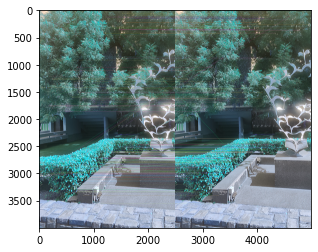

Stitched img shape is  (4003, 2516, 3)


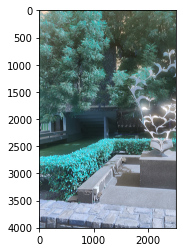

Starting Processing idx  2
The number of matching corners is  303


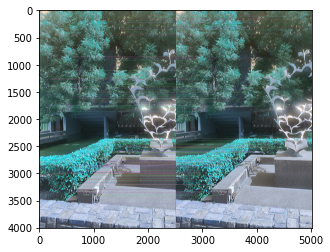

Stitched img shape is  (4005, 2544, 3)


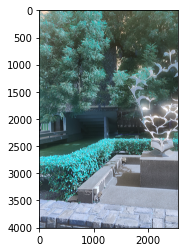

Starting Processing idx  3
The number of matching corners is  185


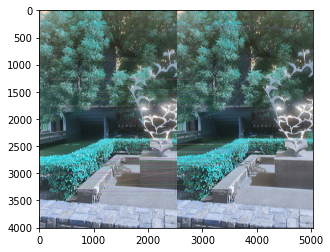

Stitched img shape is  (4006, 2572, 3)


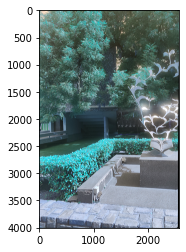

Starting Processing idx  4
The number of matching corners is  112


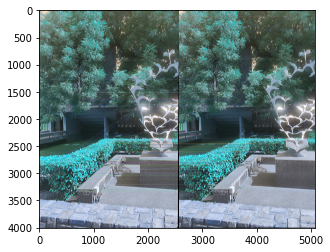

Stitched img shape is  (4006, 2580, 3)


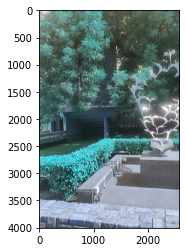

Starting Processing idx  5
The number of matching corners is  111


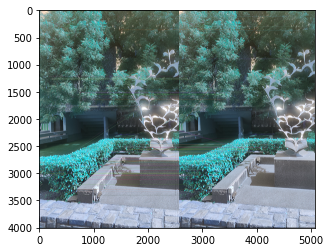

Stitched img shape is  (4006, 2600, 3)


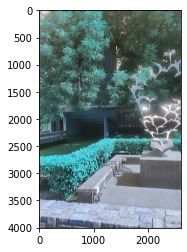

Starting Processing idx  6
The number of matching corners is  111


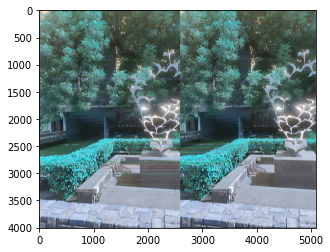

Stitched img shape is  (4006, 2606, 3)


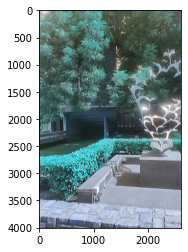

Starting Processing idx  7
The number of matching corners is  111


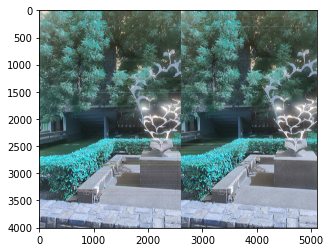

Stitched img shape is  (4006, 2640, 3)


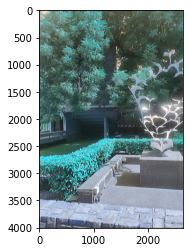

Starting Processing idx  8
The number of matching corners is  111


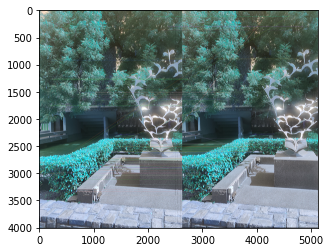

Stitched img shape is  (4006, 2660, 3)


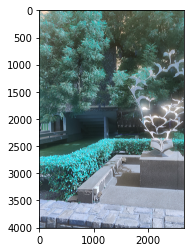

Starting Processing idx  9
The number of matching corners is  111


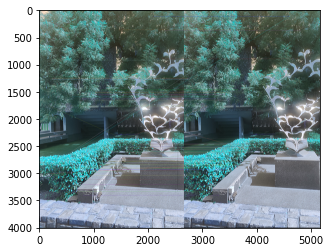

Stitched img shape is  (4006, 2680, 3)


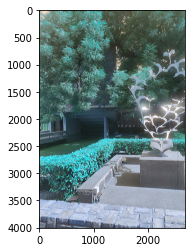

Starting Processing idx  10
The number of matching corners is  115


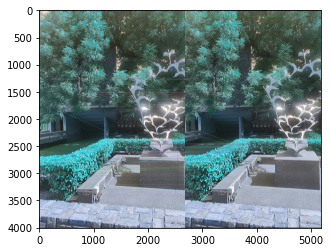

Stitched img shape is  (4029, 2713, 3)


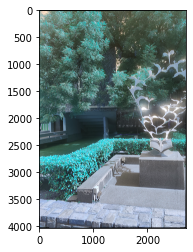

Starting Processing idx  11
The number of matching corners is  124


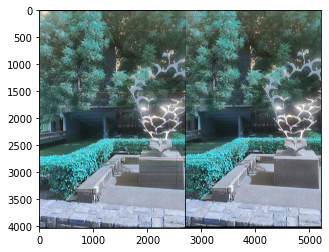

Stitched img shape is  (4033, 2733, 3)


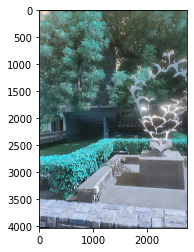

Starting Processing idx  12
The number of matching corners is  54


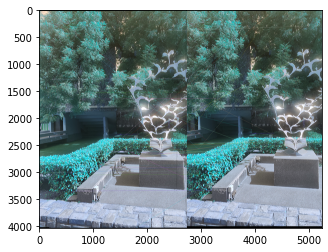

RANSAC Failed so using best fit affine transorm
Stitched img shape is  (4033, 2733, 3)


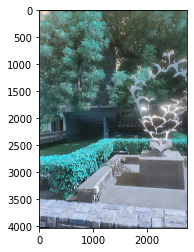

Starting Processing idx  13


In [ ]:
stitchedImg=PanaromaMatching(images)
#cv2.imwrite(resultDir+resultName ,stitchedImg)

In [ ]:
cv2.imwrite(resultDir+resultName ,stitchedImg)

In [62]:
#Ignore below this

In [79]:
refImg=cv2.imread(DataDirectoryPath+DataSet+"image 0.jpg")
affImg=cv2.imread(DataDirectoryPath+DataSet+"image 14.jpg")
#img3=cv2.imread(DataDirectoryPath+DataSet+"image 2.jpg")

In [63]:
matchingCorners1,matchingCorners2=matchingCorners(imgPreProcessing(refImg.copy()),imgPreProcessing(affImg.copy()),matchingThreshold=matchingThreshold)

The number of matching corners is  722


In [64]:
affineMatrix=RANSACFit(matchingCorners2,matchingCorners1,iter=2000)

In [65]:
affineMatrix

array([[ 1.00016358e+00, -4.01337351e-03,  5.92556784e+00],
       [-2.94757004e-03,  9.98258840e-01,  2.90789970e+01],
       [ 9.03449565e-18, -2.66713734e-17,  1.00000000e+00]])

In [66]:
h=max(refImg.shape[0],affImg.shape[0])
w=max(refImg.shape[1],affImg.shape[1])
M1 = np.float32([[1, 0, h/2], [0, 1, w/2]])
refImgCentered = cv2.transpose((cv2.warpAffine(cv2.transpose(refImg), M1,(affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1]))))
affImgCentered = cv2.transpose((cv2.warpAffine(cv2.transpose(affImg), M1,(affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1]))))

In [67]:
result = cv2.transpose(cv2.warpAffine(cv2.transpose(affImgCentered), affineMatrix[:-1], (affImg.shape[0]+refImg.shape[0], affImg.shape[1]+refImg.shape[1])))

In [68]:
dst_target=np.where(refImgCentered==np.array([0.0,0.0,0.0]),result,refImgCentered)

In [69]:
resultImg=correctBorders(dst_target)    

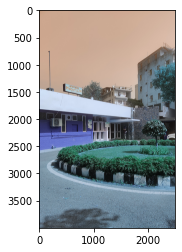

In [77]:
plt.imshow(refImg)